# BIONIC Methods Tests and Data Visualization

## Exploration and Gene Filtering

In [1]:
# imports
from itertools import combinations
import numpy as np
import pandas as pd
import csv
# import pearsonr as pearsonr
# from scipy.stats import pearsonr

In [2]:
#File Read
df = pd.read_csv("../outputs/locus_tag_processed.csv", sep=',', index_col=0, header=0)
df

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
probe_name,,,,,,,,,,,,,,
AT2G42240,110.0,95.2,91.1,133.4,97.2,121.3,85.2,125.7,92.9,127.4,92.7,102.4,102.5,112.5
AT2G42250,28.5,27.2,34.2,29.3,28.4,30.5,18.5,24.6,26.7,12.0,42.5,35.3,21.9,31.7
AT2G42270,87.8,89.8,72.2,83.4,86.0,85.2,108.0,66.4,91.0,94.6,98.6,76.5,81.6,86.3
AT2G42280,42.5,35.0,21.2,30.5,17.1,14.4,19.8,1.2,41.7,31.1,21.2,17.3,18.2,12.3
AT2G42120,262.4,282.2,248.7,266.0,209.7,235.3,204.1,289.5,228.7,213.9,248.7,275.3,233.3,246.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257585_at,4.0,6.4,5.8,9.2,1.8,1.9,17.7,2.8,8.3,2.0,4.0,10.6,5.5,1.8
AT1G50760,3.9,8.8,13.0,6.1,13.8,31.0,12.8,0.5,9.4,22.8,14.7,5.5,27.7,1.5
AT1G56310,153.5,148.0,78.4,112.0,97.2,114.7,109.8,112.8,93.4,105.7,101.7,91.2,89.2,81.6


### Pre-processes the probe names
Pre-processed the gene expression data, separating the probe names and removing the probes from organs (ATC and ATM).

In [12]:
with open('../outputs/locus_tag_processed.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    new_rows = []

    for row in reader:
        probe_names = [row[0][i:i+9] for i in range(0, len(row[0]), 9)]

        # Filter out probes from organs (ATC and ATM)
        probe_names = [probe for probe in probe_names if not probe.startswith('ATC') and not probe.startswith('ATM')]

        # Remove ATM and ATC from the list of probe names if they are aliases
        for i in range(len(probe_names)):
            if probe_names[i] == 'ATC' or probe_names[i] == 'ATM':
                probe_names.pop(i)

        new_row = [';'.join(probe_names)] + row[1:]
        new_rows.append(new_row)

with open('probes_alias_sep.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(new_rows)

###  Map probe names to gene symbols
Map the probe names to gene symbols.

In [11]:
import pandas as pd

def map_probes_to_genes(input_file, mapping_file):
    # Read the mapping file and create a dictionary mapping probe names to gene symbols
    probe_to_gene = {}
    with open(mapping_file, 'r') as map_file:
        for line in map_file:
            probe, gene = line.strip().split()
            probe_to_gene[probe] = gene

    # Read in the input file as a DataFrame
    input_df = pd.read_csv(input_file)

    # Map the gene symbols for each probe name
    gene_symbols = []
    for probe_name in input_df['probe_name']:
        if probe_name in probe_to_gene:
            gene_symbols.append(probe_to_gene[probe_name])
        else:
            gene_symbols.append(probe_name)

    # Replace the "probe_name" column with "gene_symbol"
    input_df['gene_symbol'] = gene_symbols
    input_df = input_df.drop(columns=['probe_name'])
    input_df = input_df.set_index('gene_symbol')

    # Write the output file
    input_df.to_csv('../outputs/genesym.csv')

map_probes_to_genes('../outputs/test.csv', '../gene_mapping/gene_symbol_mapping.txt')

### Scaling and Filtering

In [16]:
def check_flowering_genes(data_file, flowering_genes_file):
    """
    This functions checks how many flowering genes are in the dataset.
    :param data_file: A csv file containing the gene expression data.
    :param flowering_genes_file: The file containing the flowering genes
    :return: The number of flowering genes in the edgelist file
    """

    print("Function check_flowering_genes() is running...")

    flowering_genes = set()
    with open(flowering_genes_file, 'r') as file:
        for line in file:
            genes = line.strip().split()
            for gene in genes:
                flowering_genes.add(gene)

    # Read the data_file and count the number of flowering genes
    data_file = pd.read_csv(data_file, sep=',', header=0, index_col='gene_symbol')
    matching_genes = flowering_genes.intersection(set(data_file.index))
    num_matching_genes = len(matching_genes)

    print("Function check_flowering_genes() is complete.")
    print(f"Number of flowering genes in {data_file}: {num_matching_genes}")

check_flowering_genes('../outputs/gene_symbol_processed.csv', '../gene_mapping/flowering_genes.txt')

Function check_flowering_genes() is running...
Function check_flowering_genes() is complete.
Number of flowering genes in              35D-0H-16C-A  35D-0H-16C-B  35D-2H-16C-A  37D-2H-16C-B  \
gene_symbol                                                           
AT2G42240           110.0          95.2          91.1         133.4   
AT2G42250            28.5          27.2          34.2          29.3   
AT2G42270            87.8          89.8          72.2          83.4   
AT2G42280            42.5          35.0          21.2          30.5   
AT2G42120           262.4         282.2         248.7         266.0   
...                   ...           ...           ...           ...   
257585_at             4.0           6.4           5.8           9.2   
NLP1                  3.9           8.8          13.0           6.1   
TPS10               153.5         148.0          78.4         112.0   
TAF4B                20.7           3.0           4.9          16.4   
SON1                 28.0 

In [14]:
#File Read
df = pd.read_csv("../outputs/gene_symbol_processed.csv", sep=',', index_col=0, header=0)
df

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
gene_symbol,,,,,,,,,,,,,,
AT2G42240,110.0,95.2,91.1,133.4,97.2,121.3,85.2,125.7,92.9,127.4,92.7,102.4,102.5,112.5
AT2G42250,28.5,27.2,34.2,29.3,28.4,30.5,18.5,24.6,26.7,12.0,42.5,35.3,21.9,31.7
AT2G42270,87.8,89.8,72.2,83.4,86.0,85.2,108.0,66.4,91.0,94.6,98.6,76.5,81.6,86.3
AT2G42280,42.5,35.0,21.2,30.5,17.1,14.4,19.8,1.2,41.7,31.1,21.2,17.3,18.2,12.3
AT2G42120,262.4,282.2,248.7,266.0,209.7,235.3,204.1,289.5,228.7,213.9,248.7,275.3,233.3,246.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257585_at,4.0,6.4,5.8,9.2,1.8,1.9,17.7,2.8,8.3,2.0,4.0,10.6,5.5,1.8
NLP1,3.9,8.8,13.0,6.1,13.8,31.0,12.8,0.5,9.4,22.8,14.7,5.5,27.7,1.5
TPS10,153.5,148.0,78.4,112.0,97.2,114.7,109.8,112.8,93.4,105.7,101.7,91.2,89.2,81.6


In [17]:
df.T

probe_name,AT2G42240,AT2G42250,AT2G42270,AT2G42280,AT2G42120,AT2G42130,AT2G42150,AT2G42160,AT2G42180,AT2G42100,...,AT3G06210,AT1G50680,AT1G50720,AT1G66480,AT1G54955,257585_at,AT1G50760,AT1G56310,AT1G30150,AT1G55050
probe_aliases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AT1G51120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35D-0H-16C-A,110.0,28.5,87.8,42.5,262.4,309.2,102.6,38.6,4.2,8.3,...,70.3,13.9,1.8,33.8,1.5,4.0,3.9,153.5,20.7,28.0
35D-0H-16C-B,95.2,27.2,89.8,35.0,282.2,274.6,74.9,67.1,2.2,8.4,...,63.6,10.0,5.2,27.5,6.7,6.4,8.8,148.0,3.0,22.2
35D-2H-16C-A,91.1,34.2,72.2,21.2,248.7,241.8,116.2,65.1,2.3,6.9,...,65.3,11.8,1.7,55.3,4.8,5.8,13.0,78.4,4.9,8.7
37D-2H-16C-B,133.4,29.3,83.4,30.5,266.0,275.9,90.5,80.4,5.9,2.4,...,55.5,2.1,10.3,40.4,7.8,9.2,6.1,112.0,16.4,15.1
40D-5H-16C-A,97.2,28.4,86.0,17.1,209.7,199.0,95.2,56.8,2.3,1.9,...,84.6,7.5,7.6,43.2,2.9,1.8,13.8,97.2,4.1,10.8
40D-5H-16C-B,121.3,30.5,85.2,14.4,235.3,233.3,68.4,72.2,2.3,3.2,...,78.4,0.9,9.2,51.7,3.5,1.9,31.0,114.7,7.6,31.9
44D-9H-16C-A,85.2,18.5,108.0,19.8,204.1,296.0,71.9,58.6,14.5,1.8,...,71.4,3.4,6.7,33.1,19.2,17.7,12.8,109.8,10.0,29.8
44D-9H-16C-B,125.7,24.6,66.4,1.2,289.5,195.7,70.1,78.2,1.2,0.8,...,63.7,12.5,7.0,46.6,8.7,2.8,0.5,112.8,10.4,36.9
37D-2H-25C-A,92.9,26.7,91.0,41.7,228.7,304.2,67.2,52.1,1.2,10.0,...,84.1,3.6,1.1,67.2,10.6,8.3,9.4,93.4,20.1,7.6


In [ ]:
# Check the value ranges of the expression values for each conditions
grouped_data = df.groupby(df.columns, axis=1)
grouped_data.describe()

In [ ]:
# Plot distribution of expression values for each condition
from matplotlib import pyplot as plt

for sample, group in grouped_data:
    plt.hist(group[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.legend()

plt.show()

In [48]:
mean_expression = scaled_df.mean(axis=0)
var = scaled_df.var(axis=0)
ratio = var / mean_expression
variance_threshold = 600000000000000
filtered_df_1 = scaled_df.loc[:, ratio > variance_threshold]
filtered_df_1 = filtered_df_1.loc[:, filtered_df_1.columns.isin(filtered_df_1.columns)]
filtered_df_1.shape

(14, 11028)

In [68]:
mean_expression

array_element_name
AT2G42240   -5.273559e-16
AT2G42250    5.551115e-16
AT2G42270    8.995161e-16
AT2G42280   -3.965082e-17
AT2G42120   -1.243797e-15
                 ...     
257585_at    2.537653e-16
AT1G50760   -1.586033e-17
AT1G56310   -3.806479e-16
AT1G30150   -4.044384e-16
AT1G55050   -3.102677e-16
Length: 22393, dtype: float64

In [64]:
ratio

array_element_name
AT2G42240   -2.042118e+15
AT2G42250    1.940012e+15
AT2G42270    1.197225e+15
AT2G42280   -2.716017e+16
AT2G42120   -8.658353e+14
                 ...     
257585_at    4.243777e+15
AT1G50760   -6.790043e+16
AT1G56310   -2.829184e+15
AT1G30150   -2.662762e+15
AT1G55050   -3.470948e+15
Length: 22393, dtype: float64

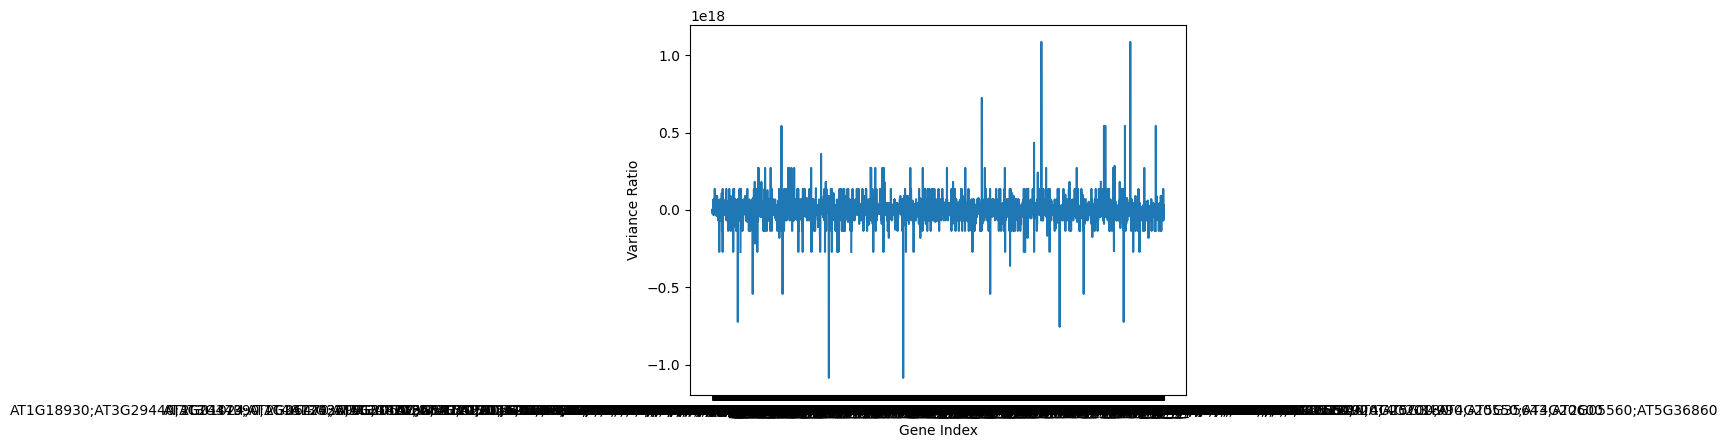

In [63]:
# Plot the variance ratio
# The variance ratio is the ratio of the variance of a gene to the mean expression
# Genes with high variance ratio indicate a high variability of expression values across samples, while a low variance ratio indicates a low variability of expression values across samples

plt.plot(ratio)
plt.xlabel("Gene Index")
plt.ylabel("Variance Ratio")
plt.show()

In [65]:
mean_expression = scaled_df.mean(axis=0)
std_expression = scaled_df.std(axis=0)

cv = np.divide(std_expression, mean_expression) * 100
cv

array_element_name
AT2G42240   -1.967834e+17
AT2G42250    1.869442e+17
AT2G42270    1.153675e+17
AT2G42280   -2.617219e+18
AT2G42120   -8.343397e+16
                 ...     
257585_at    4.089405e+17
AT1G50760   -6.543049e+18
AT1G56310   -2.726270e+17
AT1G30150   -2.565901e+17
AT1G55050   -3.344689e+17
Length: 22393, dtype: float64

In [12]:
# Remove genes through the mean absolute deviation
mad = np.mean(np.abs(scaled_df.values - mean_expression[np.newaxis, :]), axis=0)
mad
scaled_mad = mad / mean_expression
scaled_mad

variance_threshold = 0.5
filtered_df_2 = scaled_df.loc[:, scaled_mad > variance_threshold]
filtered_df_2.shape

C:\Users\anaca\AppData\Local\Temp\ipykernel_24808\463706433.py:4: RuntimeWarning: divide by zero encountered in divide
  scaled_mad = mad / mean_expression


(14, 11359)

In [15]:
# Check if the two methods give the same genes
np.array_equal(filtered_df_1.columns, filtered_df_2.columns)

True

In [ ]:
# Scale values by individual samples
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.T)
scaled_df = pd.DataFrame(scaled_df, columns=df.index, index=df.columns)

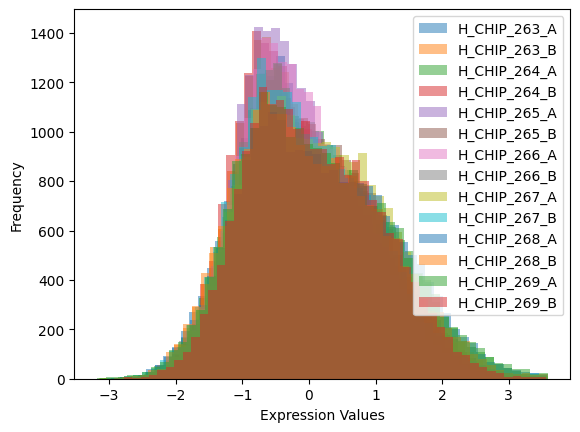

In [23]:
# Plot distribution of expression values for each condition after scaling
grouped_scl_data = scaled_df.T.groupby(scaled_df.T.columns, axis=1)
for sample, group in grouped_scl_data:
    plt.hist(group[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.legend()

plt.show()

In [31]:
# Create a new dataframe with the filtered genes
filtered_df_2.T.to_csv("reduced_output_corrected.csv")
corrected = filtered_df_2.T

In [36]:
# Split the index strings by semicolon and keep only the first part [kept only the first gene name]
corrected.index = corrected.index.str.split(';').str[0]
corrected.to_csv("reduced_output_corrected.csv")

In [17]:
# corrected.columns

In [62]:
expression_data_df = pd.read_csv("reduced_output_corrected.csv", sep=',', index_col=0, header=0)
expression_data_df.to_csv("reduced_output_corrected.csv")

In [63]:
# Delete repetitive genes
expression_data_df = expression_data_df.loc[~expression_data_df.index.duplicated(keep='first')]
expression_data_df.to_csv("reduced_output_corrected.csv")

## Old thresholding Approach

In [13]:
# Check variance of each gene across all samples
df.T.values.var(axis=0)

array([222.10209184,  51.52392857, 103.59102041, ..., 450.27632653,
        51.20637755,  77.43637755])

In [31]:
# Check the number of genes with variance above the threshold
variance_threshold = 10000
variance = df.T.values.var(axis=0)
count_var = len(variance[variance > variance_threshold])
count_var

1994

In [39]:
# Keep only the genes with variance above the threshold
reduced_df = df.T.loc[:, variance > variance_threshold]

In [43]:
reduced_df.T

,H_CHIP_263_A,H_CHIP_263_B,H_CHIP_264_A,H_CHIP_264_B,H_CHIP_265_A,H_CHIP_265_B,H_CHIP_266_A,H_CHIP_266_B,H_CHIP_267_A,H_CHIP_267_B,H_CHIP_268_A,H_CHIP_268_B,H_CHIP_269_A,H_CHIP_269_B
array_element_name,,,,,,,,,,,,,,
AT2G42210,2761.9,2341.3,2618.3,2130.1,2568.0,2538.6,2688.9,2334.4,2913.2,2294.4,2580.2,2314.7,2559.5,2477.0
AT2G42200,483.2,449.1,411.2,369.7,580.2,492.2,541.9,638.2,590.9,604.4,581.7,741.4,853.9,770.4
AT2G33040,2309.2,2130.5,2265.3,2421.0,2319.2,2820.0,2325.9,2745.9,2106.4,2437.6,2116.1,2451.6,1974.5,2292.9
AT2G26740;AT2G26750,131.4,126.3,382.4,495.2,1001.1,892.4,901.5,1283.5,348.3,603.8,414.9,463.6,498.9,562.1
AT2G26690,281.2,231.5,451.6,424.5,591.2,425.1,356.1,329.9,355.5,287.5,535.4,239.5,291.1,246.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT2G40750,604.8,427.3,708.8,696.2,448.9,363.9,530.4,359.1,182.1,144.0,79.0,95.8,72.0,112.5
AT2G24590,1338.3,1006.2,1215.9,1011.8,1134.1,792.3,1115.2,811.2,652.0,579.3,661.2,551.7,708.9,578.0
AT1G55360,558.2,676.6,657.2,720.3,766.6,724.7,754.4,880.6,973.9,1144.3,1043.2,1138.7,1061.8,1119.5


In [45]:
reduced_df.T.to_csv("reduced_output.csv")

In [53]:
red = reduced_df.T
red

,H_CHIP_263_A,H_CHIP_263_B,H_CHIP_264_A,H_CHIP_264_B,H_CHIP_265_A,H_CHIP_265_B,H_CHIP_266_A,H_CHIP_266_B,H_CHIP_267_A,H_CHIP_267_B,H_CHIP_268_A,H_CHIP_268_B,H_CHIP_269_A,H_CHIP_269_B
array_element_name,,,,,,,,,,,,,,
AT2G42210,2761.9,2341.3,2618.3,2130.1,2568.0,2538.6,2688.9,2334.4,2913.2,2294.4,2580.2,2314.7,2559.5,2477.0
AT2G42200,483.2,449.1,411.2,369.7,580.2,492.2,541.9,638.2,590.9,604.4,581.7,741.4,853.9,770.4
AT2G33040,2309.2,2130.5,2265.3,2421.0,2319.2,2820.0,2325.9,2745.9,2106.4,2437.6,2116.1,2451.6,1974.5,2292.9
AT2G26740;AT2G26750,131.4,126.3,382.4,495.2,1001.1,892.4,901.5,1283.5,348.3,603.8,414.9,463.6,498.9,562.1
AT2G26690,281.2,231.5,451.6,424.5,591.2,425.1,356.1,329.9,355.5,287.5,535.4,239.5,291.1,246.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT2G40750,604.8,427.3,708.8,696.2,448.9,363.9,530.4,359.1,182.1,144.0,79.0,95.8,72.0,112.5
AT2G24590,1338.3,1006.2,1215.9,1011.8,1134.1,792.3,1115.2,811.2,652.0,579.3,661.2,551.7,708.9,578.0
AT1G55360,558.2,676.6,657.2,720.3,766.6,724.7,754.4,880.6,973.9,1144.3,1043.2,1138.7,1061.8,1119.5


In [54]:
# split the index strings by semicolon and keep only the first part
red.index = red.index.str.split(';').str[0]

# print the modified DataFrame
red

,H_CHIP_263_A,H_CHIP_263_B,H_CHIP_264_A,H_CHIP_264_B,H_CHIP_265_A,H_CHIP_265_B,H_CHIP_266_A,H_CHIP_266_B,H_CHIP_267_A,H_CHIP_267_B,H_CHIP_268_A,H_CHIP_268_B,H_CHIP_269_A,H_CHIP_269_B
array_element_name,,,,,,,,,,,,,,
AT2G42210,2761.9,2341.3,2618.3,2130.1,2568.0,2538.6,2688.9,2334.4,2913.2,2294.4,2580.2,2314.7,2559.5,2477.0
AT2G42200,483.2,449.1,411.2,369.7,580.2,492.2,541.9,638.2,590.9,604.4,581.7,741.4,853.9,770.4
AT2G33040,2309.2,2130.5,2265.3,2421.0,2319.2,2820.0,2325.9,2745.9,2106.4,2437.6,2116.1,2451.6,1974.5,2292.9
AT2G26740,131.4,126.3,382.4,495.2,1001.1,892.4,901.5,1283.5,348.3,603.8,414.9,463.6,498.9,562.1
AT2G26690,281.2,231.5,451.6,424.5,591.2,425.1,356.1,329.9,355.5,287.5,535.4,239.5,291.1,246.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT2G40750,604.8,427.3,708.8,696.2,448.9,363.9,530.4,359.1,182.1,144.0,79.0,95.8,72.0,112.5
AT2G24590,1338.3,1006.2,1215.9,1011.8,1134.1,792.3,1115.2,811.2,652.0,579.3,661.2,551.7,708.9,578.0
AT1G55360,558.2,676.6,657.2,720.3,766.6,724.7,754.4,880.6,973.9,1144.3,1043.2,1138.7,1061.8,1119.5


In [56]:
red.to_csv("reduced_output.csv")